## 1. Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import time

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

dataset_path = "dataset"
train_dir = 'dataset/train'
validation_dir = 'dataset/test'
model_dir = 'modelcp'

BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

## 2. Data Preprocessing

In [2]:
# Generate more variants of images to fit training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255) 

# Load and apply image transformation to the training and validation data
train_generator = train_datagen.flow_from_directory( 
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 64 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


In [3]:
if not os.path.exists(model_dir):
        os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

# Find out label catgories
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'audi', 1: 'lamborghini', 2: 'mercedes'}

## 3. ResNet50

In [4]:
# ResNet50V2 Model
def create_model(summary=True):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 

    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1.0e-5)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if summary:
        print(model.summary())
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

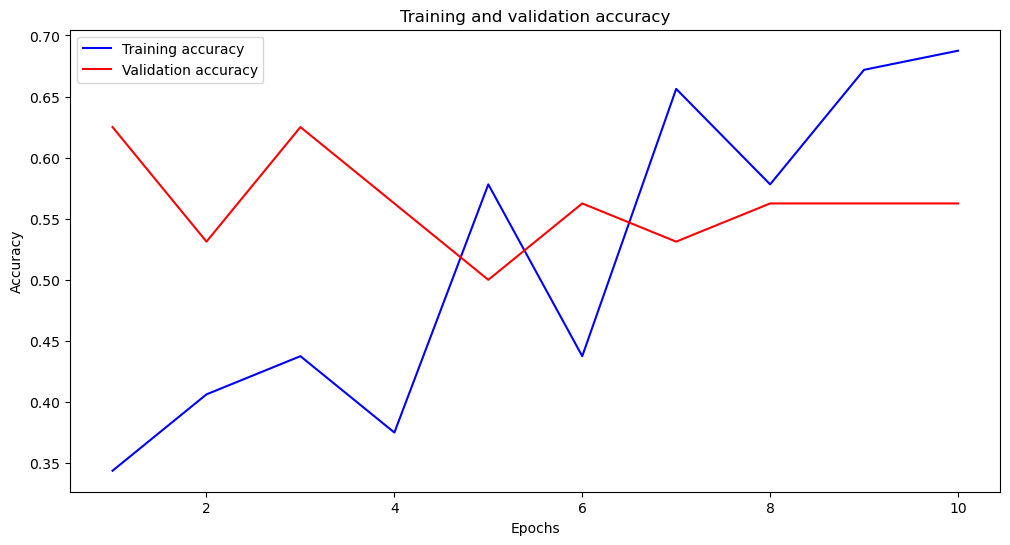

In [5]:
model = create_model()

training_start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[cp_callback]
)

training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"Total training time: {total_training_time: .2f} seconds")

# After training, extract final metrics from the history
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final metrics
print(f"Final training accuracy: {final_train_acc * 100:.2f}%")
print(f"Final validation accuracy: {final_val_acc * 100:.2f}%")
print(f"Final training loss: {final_train_loss:.2f}")
print(f"Final validation loss: {final_val_loss:.2f}")
    
# Plot the accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
# plt.savefig("accuracy.png")

Remarks: The existing dataset is incompatible, leading to poor validation accuracy despite fine-tunning. This is because the train and test images differ significantly from each other.
This is the best available dataset I could find and it primarily serves to showcase my computer vision coding skill.

In [6]:
# Return checkpoint file 
latest = tf.train.latest_checkpoint(checkpoint_dir)

# Create a new model instance
loaded_model = create_model(summary=True)

# Load the previously saved weights into the model
loaded_model.load_weights(latest)

loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [7]:
# Display image
def show_img(img_array, title):
        plt.title(title)
        plt.imshow(img_array)
        plt.axis("off")
        
        plt.show()

# Generate a Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        
        model.layers[-1].activation = None
        grad_model = tf.keras.models.Model(
                [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )
        
        # Compute gradients
        with tf.GradientTape() as tape:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:  
                        pred_index = tf.argmax(preds[0])
                        print(pred_index.numpy())
                class_channel = preds[:, pred_index] 

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0)
        max_val = tf.math.reduce_max(heatmap)
 
        if max_val > 0.04: 
                heatmap = tf.where(heatmap<0.04, 0, heatmap)
                heatmap = heatmap / max_val
        else: 
                heatmap = tf.zeros_like(heatmap)

        print("Max value in heatmap: ", max_val.numpy())

        return heatmap.numpy()

# Display Grad-Cam
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
        # Load the original image and convert to array format
        img = tf.keras.preprocessing.image.load_img(img_path)
        img = tf.keras.preprocessing.image.img_to_array(img)
        
        # Rescale heatmap back to a range 0-255, pixel has 255 values 
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
        
        show_img(superimposed_img, 'IMAGE OUT: Grad-CAM')

ACTUAL LABEL: Mercedes


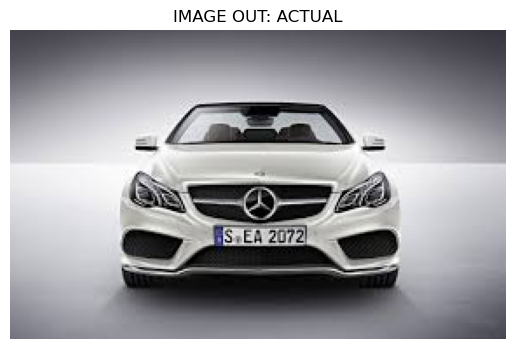

1/1 [==============================] - 0s 82ms/step
PRED LABEL: Mercedes
2
Max value in heatmap:  0.049019746


C:\Users\Chun Quan\AppData\Local\Temp\ipykernel_9696\3510283229.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


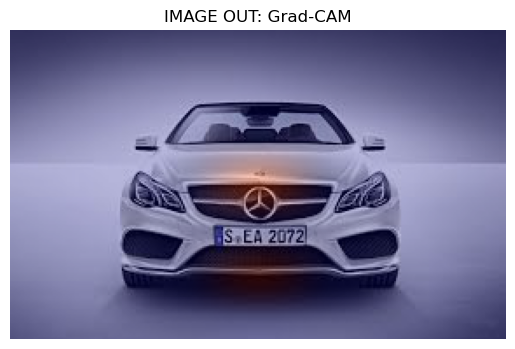

In [14]:
# Preidction
def make_prediction_and_visualize():
        val_path = dataset_path + '/test'

        # Randomly choose a class for the test
        class_idx = np.random.randint(0, 3)

        label_mapping = {
                0: ('audi', 'Audi'),
                1: ('lamborghini', 'Lamborghini'),
                2: ('mercedes', 'Mercedes'),
        }

        folder, actual_label = label_mapping[class_idx]
        print(f'ACTUAL LABEL: {actual_label}')
        
        folder = os.path.join(val_path, folder)

        img_paths = os.listdir(folder)
        folder_size = len(img_paths)

        # Randomly choose a pict for the test
        idx = np.random.randint(0, folder_size)
        img_path = folder + '/' + img_paths[idx]
        img = cv2.imread(img_path)
        show_img(img[:,:,[2,1,0]], 'IMAGE OUT: ACTUAL')
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        rescaled_img = img/255.0
        batch_pred = np.expand_dims(rescaled_img, 0)
        pred = np.argmax(loaded_model.predict(batch_pred)[0])

        predicted_label = list(label_mapping.values())[pred][1]
        print(f'PRED LABEL: {predicted_label}')

        last_conv_layer_name = 'conv5_block3_out'

        heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name) 
        save_and_display_gradcam(img_path, heatmap)

make_prediction_and_visualize()